# Gradient Descent from Scratch
In this tutorial, we will be building gradient descent algorithm from the scratch
using `tensors` that we learned in the previous topic. It will test your knowledge
on `tensors` and its operations. First, we will import all
the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from fastai.vision.all import *

# Autograd
A tensor can be created with `requires_grad=True` so that `torch.autograd` records operations on them for automatic differentiation. For example, we know that if some function is $f(x) = x^2$, its derivative with respect to its variable $x$ will be $\frac{\mathrm{df(x)}}{\mathrm{dx}}=2x$. Therefore, for some random value of the variable $x$, say, $2$, the derivative of the function will be $\frac{\mathrm{df(2)}}{\mathrm{dx}}=2(2)=4$

In [2]:
def f(x: tensor) -> tensor:
    return x ** 2

In [3]:
x = torch.tensor([2], dtype=torch.float32, requires_grad=True)
x

tensor([2.], requires_grad=True)

In [4]:
y = f(x)
y

tensor([4.], grad_fn=<PowBackward0>)

The `backward` function will calculate derivatives of all the variable involved in the computation. After that, you can simply access the `grad` property of each variable.

In [5]:
y.backward()
print("The dervative at x = 2: ", x.grad)

The dervative at x = 2:  tensor([4.])


Now, we will do the same when inputs have multiple data points. Now our function will be $f(x_{1}, x_{2}, x_{3}, x_{4}) = x^{2}_{1} + x^{2}_{2} + x^{2}_{3} + x^{2}_{4}$. Since we have $4$ variables now, such as $x_{1}, x_{2}, x_{3},$ and $x_{4}$, we can not simply compute the derivative. Now we have to compute the partial derivatives of the function $f(x)$ with respect to all the variables individually. Here the partial derivatives will be $\frac{df}{dx_{1}} = 2{x_{1}}$, $\frac{df}{dx_{2}} = 2{x_{2}}$, $\frac{df}{dx_{3}} = 2{x_{3}}$, $\frac{df}{dx_{4}} = 2{x_{4}}$.

In [6]:
x = torch.tensor([2, -2, 3, -3], dtype=torch.float32, requires_grad=True)
x

tensor([ 2., -2.,  3., -3.], requires_grad=True)

In [7]:
y = f(x)
y = y.sum()

In [8]:
y.backward()
print("The dervative at x = 2: ", x.grad)

The dervative at x = 2:  tensor([ 4., -4.,  6., -6.])


# Gradient Descent
Let's create a simple dataset first. Suppose, this dataset is about the speed of a vehicle from start to any finite time.

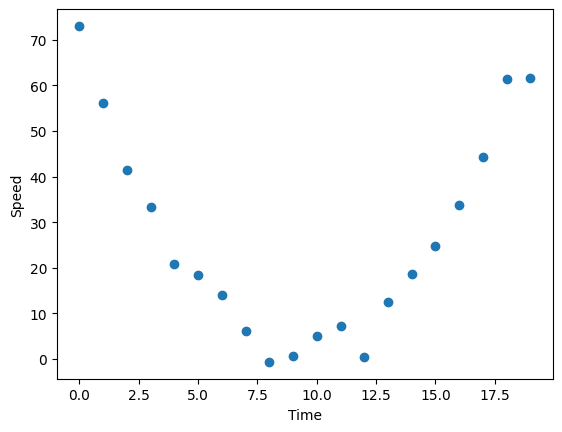

In [9]:
time = torch.arange(0, 20).float()
speed = torch.randn(20) * 3 + 0.75 * (time - 9.5)**2 + 1

plt.scatter(time, speed)
plt.xlabel('Time')
plt.ylabel('Speed')
plt.show()

Suppose, we are going to predict the speed of the vehicle given the time using the formula $a\times(time^2)+(b\times time)+c$. Now, from the previous cell, you know that the value of $a$ will be 0.75, $b$ is 3, and $c$ is 1. However, we will estimate these values from the data using gradient descent algorithm.

Here $a, b,$ and $c$ are the parameters of our model beacuse we do not know the value of them. It is the job of the algorithm to find the optimal values for these parameters so that our prediction is as good as possible.

In [10]:
def f(time: tensor, params: tensor) -> tensor:
    a, b, c = params
    return a*(time**2) + b*time + c

Next, we have to define a function to measure how good our prediction is.

In [11]:
def mean_square_error(preds: tensor, targets: tensor) -> tensor:
    return ((preds - targets)**2).mean()

Let's create and initialize the values for our parameters $a, b,$ and $c$.

In [12]:
params = torch.randn(3).requires_grad_()
print('Initial value for a: ', params[0])
print('Initial value for b: ', params[1])
print('Initial value for c: ', params[2])

Initial value for a:  tensor(0.3137, grad_fn=<SelectBackward0>)
Initial value for b:  tensor(0.6482, grad_fn=<SelectBackward0>)
Initial value for c:  tensor(-1.1443, grad_fn=<SelectBackward0>)


Now, let's predict with the randomly initialized parameters. As you can see, our predictions are far away from the actual values.

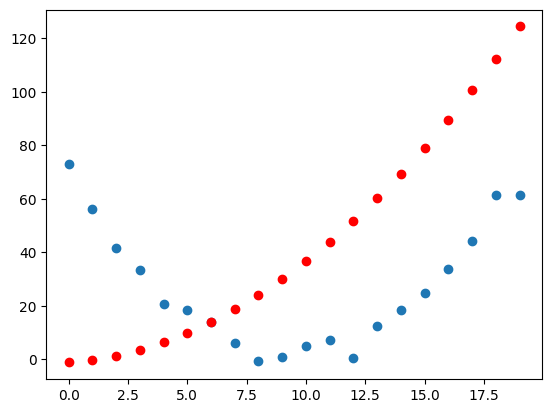

In [13]:
preds = f(time, params)

plt.scatter(time, speed)
plt.scatter(time, to_np(preds), color='red')
plt.show()

Let's calculate the error of our model using the mean square error function that we just wrote.

In [14]:
loss = mean_square_error(preds, speed)
print(loss.item())

1936.605224609375


Now, we will calculate the partial derivatives of this error with respect to all the parameters that contributed the error. Then we will update our paramters using the partial derivatives and a learning rate.

In [15]:
loss.backward()

In [16]:
lr = 1e-5
params.data = params.data - lr * params.grad
params.grad = None

Let's see if our predictions have improved. As you will see, our predictions have improved a little, and our loss is also decreased.

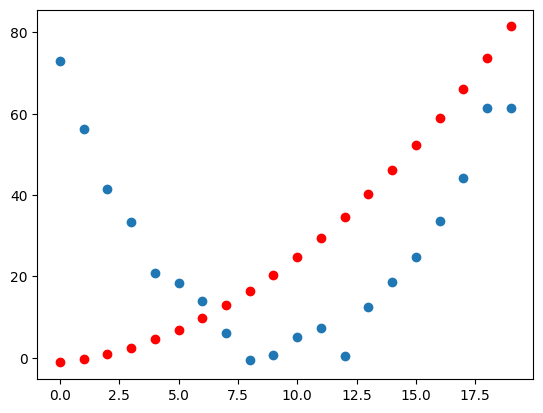

In [17]:
preds = f(time, params)

plt.scatter(time, speed)
plt.scatter(time, to_np(preds), color='red')
plt.show()

In [18]:
loss = mean_square_error(preds, speed)
print(loss.item())

921.4987182617188


Let's write all the steps of the gradient descen in a single function.

In [19]:
def step(params):
    preds = f(time, params)
    loss = mean_square_error(preds, speed)
    loss.backward()
    params.data = params.data - lr * params.grad
    params.grad = None
    return preds

Now let's check how our predictions improve with time.

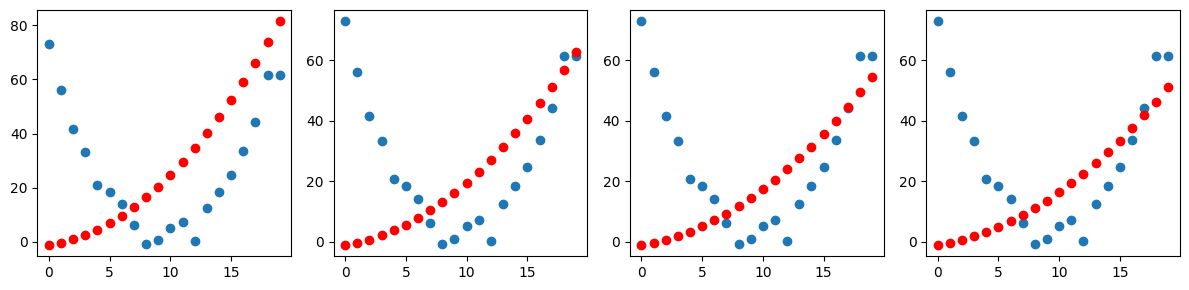

In [20]:
_, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax in axs:
    preds = step(params)
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
plt.tight_layout()
plt.show()

# MNIST Dataset
We will use the MNIST Sample dataset from the `Fastai` repository. This dataset contains
a stripped down version of the actual MNIST hand written digits. It contains the digits
$3$ and $7$ only. Our task will be build a `Logistic Regression` classifier to classify
the digits. First, we will create dataloaders for both training and validation data.

In [21]:
# Loads MNIST dataset from Fast.ai repository
# This trimmed dataset contains only 3s and 7s
path = untar_data(URLs.MNIST_SAMPLE)

### Training Set

In [22]:
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes = torch.stack(three_tensors).float() / 255

In [23]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)

train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

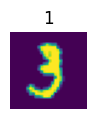

In [24]:
dset = list(zip(train_x, train_y))

x, y = dset[0]
show_titled_image((x.view(28, 28), str(y.item())))

### Validation Set

In [25]:
valid_stacked_threes = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_stacked_threes = valid_stacked_threes.float() / 255

valid_stacked_sevens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]) 
valid_stacked_sevens = valid_stacked_sevens.float() / 255

In [26]:
valid_x = torch.cat([valid_stacked_threes, valid_stacked_sevens]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_stacked_threes) + [0]*len(valid_stacked_sevens)).unsqueeze(1)

valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

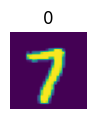

In [27]:
valid_dset = list(zip(valid_x, valid_y))

x, y = valid_dset[-1]
show_titled_image((x.view(28, 28), str(y.item())))

# Model
We will use a 2 layer neural network where the first hidden layer has 16 neurons and
the second hidden layer has 8 neurons. Our images are of size $28\times28$. 
Therefore we will need a total number of $784\times16$ weights for our first hidden
layer, in addition to $16$ bias parameters. In the second hidden layer, we will need
$16\times8$ weights and $8$ bias parameters. Finally, in the output layer, we will
need $8\times1$ weights and $1$ parameters.

### Initialize Parameters
We will be needing one weight for each pixel. So, let's write a function that will initialize
parameters of a given size.

In [28]:
def init_params(size, std=0.1):
    return (torch.randn(size) * std).requires_grad_()

In [29]:
w1 = init_params((28*28, 16))
b1 = init_params(16)
w2 = init_params((16, 8))
b2 = init_params(8)
w3 = init_params((8, 1))
b3 = init_params(1)

In [30]:
print(w1.data.shape)
print(b1.data.shape)
print(w2.data.shape)
print(b2.data.shape)
print(w3.data.shape)
print(b3.data.shape)

torch.Size([784, 16])
torch.Size([16])
torch.Size([16, 8])
torch.Size([8])
torch.Size([8, 1])
torch.Size([1])


### Activation Functions
We will define some useful activation functions that will be used in the model. We
will use `relu` in the hidden layers, and `sigmoid` for prediction.

In [31]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

In [32]:
def relu(x):
    return x.max(tensor(0.0))

### Model

In [33]:
def forward(x):
    x = x @ w1 + b1
    x = relu(x)
    x = x @ w2 + b2
    x = relu(x)
    x = x @ w3 + b3
    x = sigmoid(x)
    return x

### Loss Function
We will need a loss function for gradient descent. In this custom loss function,
we are simply calculating the distance from the prediction and the actual target.
Since the prediction will be ranged between $0$ and $1$ due the `sigmoid` function
in the output layer, we can safely avoid `MSE` loss function.

In [34]:
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

### Training

In [35]:
lr = 0.01
epochs = 25

In [36]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [37]:
for epoch in range(epochs):
    losses = []

    for xb, yb, in dl:
        preds = forward(xb)
        loss = mnist_loss(preds, yb)
        losses.append(loss.item())
        loss.backward()

        w1.data -= w1.grad * lr
        w2.data -= w2.grad * lr
        w3.data -= w3.grad * lr

        b1.data -= b1.grad * lr
        b2.data -= b2.grad * lr
        b3.data -= b3.grad * lr

        w1.grad.zero_()
        w2.grad.zero_()
        w3.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()
        b3.grad.zero_()
    
    acc = []
    for vx, vy in valid_dl:
        v_preds = forward(vx)
        v_preds = torch.where(v_preds >= 0.5, 1, 0)
        acc.append(torch.sum(v_preds == vy).item() / vx.shape[0])

    print("Epoch {}: Loss {}, Validation Accuracy {}".format(epoch, sum(losses) / len(losses), 
            sum(acc) / len(acc)))

Epoch 0: Loss 0.5040188973047295, Validation Accuracy 0.4550979738313008
Epoch 1: Loss 0.503042145651214, Validation Accuracy 0.47171938516260165
Epoch 2: Loss 0.502170747031971, Validation Accuracy 0.48539126016260165
Epoch 3: Loss 0.501364527308211, Validation Accuracy 0.4966812754065041
Epoch 4: Loss 0.5005788486831042, Validation Accuracy 0.5059983168191057
Epoch 5: Loss 0.49977350782374946, Validation Accuracy 0.516819899644309
Epoch 6: Loss 0.4988990797072041, Validation Accuracy 0.5291063262195121
Epoch 7: Loss 0.49789922821278476, Validation Accuracy 0.5428774453760162
Epoch 8: Loss 0.4967035523482731, Validation Accuracy 0.5660450012703252
Epoch 9: Loss 0.4952144835676466, Validation Accuracy 0.5867116044207317
Epoch 10: Loss 0.49329826296592244, Validation Accuracy 0.624706237296748
Epoch 11: Loss 0.4907504855370035, Validation Accuracy 0.6676829268292683
Epoch 12: Loss 0.48727431893348694, Validation Accuracy 0.7007153518800813
Epoch 13: Loss 0.48241686699341757, Validation 